<a href="./">Go to this directory index</a>

Contents

  - [Ammonia2: iterative solver for aqua-ammonia absorption cycle¶](#Ammonia2:-iterative-solver-for-aqua-ammonia-absorption-cycle)

In [2]:
%%html
<img src="../img/Diagram_for_ammonia.svg"><!-- In source distro-->
<img src="./img/Diagram_for_ammonia.svg"><!-- In web docs -->

# Ammonia2: iterative solver for aqua-ammonia absorption cycle

The previous ammonia-water cycle model (`import ammonia1`) solved the cycle by inputing internal temperatures at the endpoints of heat exchange processes, then solved for UA by the heat exchanger integral equation. Suppose instead we want to input heat exchanger and pump specifications for the system above, then solve for the internal temperatures. How then do we solve the cycle?

First let's compare inputs to recognize where we might need to change assumptions.

<table>
<tr>
<th>Set of inputs for easy update (ammonia1)</th>
<th>Set of inputs for build specification</th>
<th>Set of inputs for operating spec.</th>
<th>Equivalent input for ammonia2</th>
</tr>
<tr>
<td>
$T_{cond}$<br>
$T_{evap}$<br>
$T_{abs}$<br>
$T_{gen}$<br>
$T_{rect}$<br>
$\dot{m}$<br>
Subcooling $\Delta T_{cond}$<br>
Superheat $\Delta T_{evap}$<br>
Assume $P_{evap}$ for absorber properties
</td>
<td>
$UA_{cond}$<br>
$UA_{evap}$<br>
$UA_{abs}$<br>
$UA_{gen}$<br>
$UA_{rect}$<br>
Pump curve<br>
Solution valve minor loss coeffcient<br>
Refrigerant valve minor loss coefficient<br>
Absorption mass transfer resistance
</td>
<td>
"<br>"<br>"<br>"<br>"<br>
Pump power input<br>
(Adjustable)<br>
(Adjustable)<br>
"
</td>
<td>
"<br>"<br>"<br>"<br>"<br>
$\dot{m}$<br>
Assume $P_{cond}$ calculated from $T_{cond}$<br>
Assume $P_{evap}$ calculated from $T_{evap}$<br>
Assume $P_{evap}$ for absorber properties
</td>
</tr>
<tr><th>Ammonia1 outputs</th><th></th><th></th><th>Ammonia2 outputs</th></tr>
<tr>
<td>Pressure drop from evaporator to absorber</td>
<td></td>
<td></td>
<td>Equilibrium pressure in absorber</td>
</tr>
</table>

Presuming that we want the models to behave similarly, the valve settings and pressures will need to be determined by the equilibrium pressure based on temperatures in the condenser (for high pressure) and evaporator (for low pressure). This is a potential pitfall; what do we do when the temperature in the ... . 

But let's proceed and see what happens. First, we give the program a basic structure:

```python
def program(initial_condition,time_to_run):
    initialize(initial_condition)
    while time < time_to_run:
        update()
```

The initial condition is needed to evaluate properties for the first time step, and looks like an input to `ammonia1`, ie. specifies state points throughout the system. During the update, since there are multiple types of variables evolving, we need to propose how to update them. A very simple procedure would be:

```python
def update():
    for component in heat_exchangers:
        component.fdm_update() # Using finite difference method for heat exchange,
                               # sets enthalpies, mass fractions, and flow rates
                               # for each outlet port.
    update_pressures()
```



In [9]:
from ammonia1 import AmmoniaChiller
ch = AmmoniaChiller()
ch

,T,P,x,h,s,u,v,Qu
rich_abs_outlet,400,10,0.5,1107.51,3.63631,1014.08,0.0934303,0.507665
rich_pump_outlet,400,10,0.5,1107.51,3.63631,1014.08,0.0934303,0.507665
rich_shx_outlet,400,10,0.5,1107.51,3.63631,1014.08,0.0934303,0.507665
rich_gen_sat_liquid,400,10,0.5,1107.51,3.63631,1014.08,0.0934303,0.507665
weak_gen_outlet,400,10,0.5,1107.51,3.63631,1014.08,0.0934303,0.507665
weak_shx_outlet,400,10,0.5,1107.51,3.63631,1014.08,0.0934303,0.507665
weak_exp_outlet,400,10,0.5,1107.51,3.63631,1014.08,0.0934303,0.507665
gen_vapor_outlet,400,10,0.5,1107.51,3.63631,1014.08,0.0934303,0.507665
gen_reflux_inlet,400,10,0.5,1107.51,3.63631,1014.08,0.0934303,0.507665
refrig_rect_outlet,400,10,0.5,1107.51,3.63631,1014.08,0.0934303,0.507665


In [ ]:
class amm2_absorber_stream:
    def __init__():
        pass
    def q():
        pass
    def c():
        pass
        

def amm2_get_absorber_stream(ch):
    

def amm2_update(ch,UA_abs,UA_gen,UA_cond,UA_evap,UA_rect):
    # Absorber
    # SHX
    # Generator
    # Rectifier
    # Condenser
    # Evaporator
    # CEHX
    
    
    

As a digression, my previously developed approach to FDM solution of HX problems requires the heat capacities of each stream. If we use a model of the streams based on a discrete number of precomputed points, then we would want to obtain the heat capacity from derivatives of the (Q,T) curve. However, interpolates are not necessarily good for that, as I will show below.

The alternative is that we *avoid* precomputing points for the FDM model. Instead, we need to also supply a function to compute heat capacity, and that requires we establish the math beforehand. So, here is an opportunity.

The stream heat capacity is
$$C_{stream} = \left(\frac{dq}{dT} \right).$$

However, since most straightforward functional approach is to compute $T(q)$, we could rewrite as:
$$ C_{stream}^{-1} = \left(\frac{dT}{dq} \right).$$

Where there is a phase change process at constant temperature, $C_{stream}$ may be infinite but $C_{stream}^{-1}$ could be computed. When both streams have phase change at constant temperature, effectiveness is not required and the UA-LMTD equation alone can be used.

Another thought missing from the FDM code development notes is that we could approximate the LMTD using the current temperatures at inlet and outlet. The accuracy of the result then depends on the approximation. With this approach, by returning to the LMTD equation, numerical issues may arise when an initial condition causes inversion (the labels 'cold' and 'hot' might apply to different streams at opposite ends of the HX) or matched capacities. Perhaps we could start off with a more generous approximation, such as a linear average temperature difference (which works even for a case of inversion), and slide toward the LMTD for *nicer* cases.

In [38]:
from numpy import inf, linspace
from scipy.interpolate import PchipInterpolator, CubicSpline
x = [0,1,2,3,4,5,6,7,8,8,8,9,10]
y = [0,1,2,2,2,3,4,5,6,7,8,9,10]
spliner = PchipInterpolator
py = spliner(x,y)
px = spliner(y,x)

C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


This would look nicer, but doesn't accept the given points!

In [39]:
spliner = CubicSpline
py = spliner(x,y)
px = spliner(y,x)

ValueError: `x` must be strictly increasing sequence.

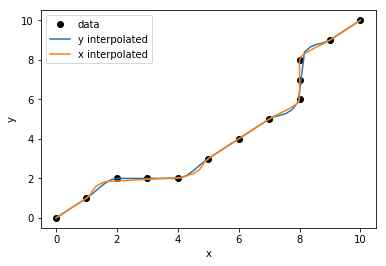

In [40]:
import matplotlib.pyplot as plt
xs = linspace(0,10)
ys = linspace(0,10)
plt.plot(x,y,'ko',label='data')
plt.plot(xs,py(xs),'-',label='y interpolated')
plt.plot(px(ys),ys,'-',label='x interpolated')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
?py.derivative

C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\interpolate.py:1406: RuntimeWarning: invalid value encountered in true_divide
  c2 = k * np.diff(self.c, axis=0) / dx
C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


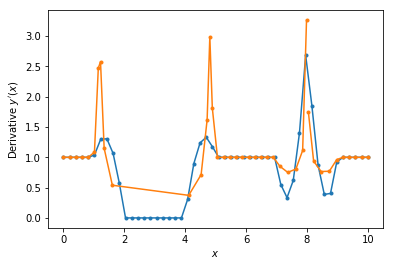

In [32]:
py_prime = py.derivative()
px_prime = px.derivative()
plt.plot(xs,py_prime(xs),'.-')
plt.plot(px(ys),1/px_prime(ys),'.-')
plt.xlabel('$x$')
plt.ylabel("Derivative $y'(x)$")
plt.show()

Let's get back to the series I developed for LMTD that avoids the problem of matched heat capacities. If we actually implement it, do we need to compute it to hardware precision? How well does it converge, and can convergence be accelerated?

The series comes from this equation:

$$\Delta T_{LM} = \Delta T_{A} \left(\sum_{k=0}^{\infty} \frac{(-\delta)^{k}}{k+1} \right)^{-1} $$

where $\delta := R - 1$ and $R = \Delta T_B / \Delta T_A$. So the series function we need to compute is

$$f_n(x) = \sum_{k=0}^{n} \frac{(-x)^{k}}{k+1}.$$

Here are some examples:

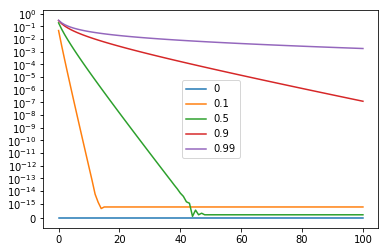

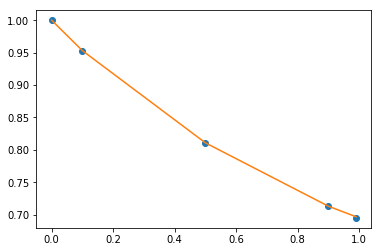

In [68]:
from numpy import log, abs, array
def seriesTrue(x):
    if x == 0:
        return 1
    else:
        return log(1+x)/x
def series1(x,n, sequence=False):
    f = 0
    df = 1
    f += df
    dfs = []; dfs.append(df)
    fs = []; fs.append(f)
    for k in range(1,n+1):
        df *= (-x) * (k) / (k+1)
        f += df
        if sequence:
            dfs.append(df)
            fs.append(f)
    if sequence:
        return f, fs, dfs
    else:
        return f

fig1=plt.figure()
ax1 = plt.subplot(111)
ax1.set_yscale('symlog',linthreshy=1e-15)
ftrues=[]
fseries = []
xs=[0, 0.1, 0.5, 0.9, 0.99]
for x in xs:
    ftrue = seriesTrue(x)
    ftrues.append(ftrue)
    f, fs, dfs = series1(x, 100, True)
    fseries.append(f)
    ax1.plot(abs(ftrue - array(fs)), label='{:g}'.format(x),)
plt.legend()
plt.figure()
plt.plot(xs, ftrues,'o', xs, fseries,'-')
plt.show()

In [64]:
?ax1.set_yscale

# Table of contents generator

In [35]:
%%html
<pre id="TOC-markdown">TOC will be here</pre>
<script>
$("#TOC-markdown").html(
    $('h1,h2,h3,h4').filter(":has(a)").map(function(){return "  ".repeat($(this).prop("tagName")[1]) + "- ["+$(this).text()+"](" + $(this).children().attr("href") + ")";}).get().join("\n")
    );
</script>